# Torch Batteries: TensorBoard & WandB Integration

This notebook demonstrates how to use the `torch-batteries` library's experiment tracking capabilities with both **TensorBoard** and **Weights & Biases (WandB)**. We'll fit a noisy polynomial function using an MLP to showcase real-world training scenarios.

## Overview

We'll be fitting a noisy polynomial function: `y = (x-1)(x-6)(x-7) + noise` using a neural network, while tracking experiments with:
- **TensorBoard**: Local experiment visualization
- **WandB**: Cloud-based experiment tracking and collaboration

## 0. Installation

Install torch-batteries with TensorBoard and WandB support:

In [28]:
%pip install torch-batteries[example,tensorboard,wandb]

/home/arkadiusz/coding/university/isi2/torch-batteries/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Dependencies

First, let's import the required libraries and check the versions.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F  # noqa: N812
from torch.utils.data import DataLoader, TensorDataset

import torch_batteries
from torch_batteries import Battery, Event, charge
from torch_batteries.callbacks import ExperimentTrackingCallback
from torch_batteries.events import EventContext
from torch_batteries.tracking import Run
from torch_batteries.tracking.tensorboard import TensorBoardTracker
from torch_batteries.tracking.wandb import WandbTracker

print(f"torch-batteries version: {torch_batteries.__version__}")
print(f"PyTorch version: {torch.__version__}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch-batteries version: 0.5.0
PyTorch version: 2.9.1+cu128


## 2. Data Preparation with Noise

We'll create a synthetic dataset by sampling from the polynomial function `y = (x-1)(x-6)(x-7)` and **add Gaussian noise** to simulate real-world data. This makes the learning problem more realistic and interesting to track.

In [30]:
# Generate data with noise
x = np.linspace(0, 10, 500).reshape(-1, 1).astype(np.float32)
y_clean = ((x - 1) * (x - 6) * (x - 7)).astype(np.float32)

# Add Gaussian noise (scaled relative to signal magnitude)
NOISE_SCALE = 5.0  # Standard deviation of the noise
noise = np.random.normal(0, NOISE_SCALE, y_clean.shape).astype(np.float32)
y_noisy = y_clean + noise

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y_noisy)
y_clean_tensor = torch.from_numpy(y_clean)

BATCH_SIZE = 32

# Full dataset for prediction visualization
pred_full_dataset = TensorDataset(x_tensor, y_tensor)
pred_full_loader = DataLoader(pred_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Split data into train/validation/test sets
x_train, x_rest, y_train, y_rest = train_test_split(
    x_tensor, y_tensor, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_rest, y_rest, test_size=0.5, random_state=42
)

# Create datasets and data loaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Noise scale: {NOISE_SCALE}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")

Noise scale: 5.0
Training samples: 350
Validation samples: 75
Test samples: 75
Batch size: 32


### Visualize the Noisy Data

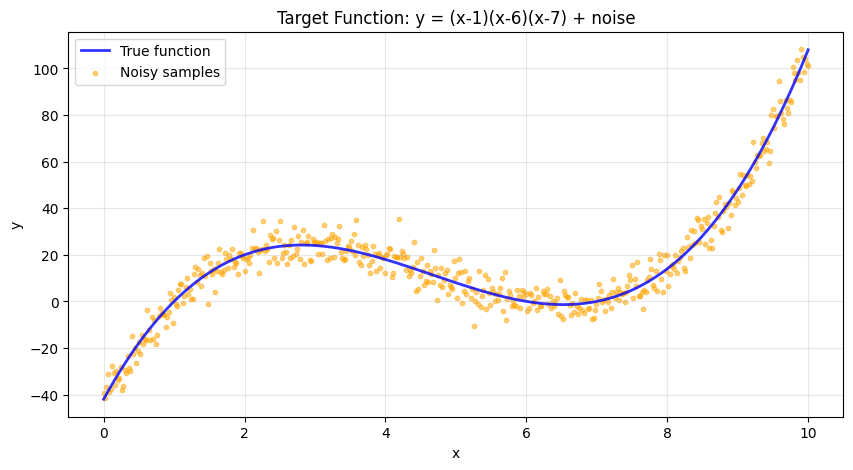

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(x, y_clean, 'b-', linewidth=2, label='True function', alpha=0.8)
plt.scatter(x, y_noisy, c='orange', s=10, alpha=0.5, label='Noisy samples')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target Function: y = (x-1)(x-6)(x-7) + noise')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Model Definition

We define our MLP model using the `@charge` decorator to specify training, validation, testing, and prediction steps.

In [32]:
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.network(x)

    @charge(Event.TRAIN_STEP)
    def training_step(self, context: EventContext):
        """Define what happens in each training step."""
        batch = context["batch"]
        x, y = batch
        pred = self(x)
        return F.mse_loss(pred, y)

    @charge(Event.VALIDATION_STEP)
    def validation_step(self, context: EventContext):
        """Define what happens in each validation step."""
        batch = context["batch"]
        x, y = batch
        pred = self(x)
        return F.mse_loss(pred, y)

    @charge(Event.TEST_STEP)
    def test_step(self, context: EventContext):
        """Define what happens in each test step."""
        batch = context["batch"]
        x, y = batch
        pred = self(x)
        return F.mse_loss(pred, y)

    @charge(Event.PREDICT_STEP)
    def prediction_step(self, context: EventContext):
        """Define what happens during prediction."""
        batch = context["batch"]
        x = batch[0]
        return self(x)


# Define metric functions
def mae_metric(pred, target):
    """Calculate Mean Absolute Error."""
    return F.l1_loss(pred, target)


def rmse_metric(pred, target):
    """Calculate Root Mean Squared Error."""
    return torch.sqrt(F.mse_loss(pred, target))

## 4. Training with Both TensorBoard and WandB

We'll train a single model while tracking with **both** TensorBoard and WandB simultaneously. This demonstrates how `torch-batteries` supports multiple trackers via the callback system.

**Note**: You'll need to have a WandB account and be logged in. Run `wandb login` in your terminal if you haven't already.

In [ ]:
# Hyperparameters
LEARNING_RATE = 0.001
HIDDEN_DIM = 64
EPOCHS = 100

# Create model and optimizer
model = MLPModel(input_dim=1, hidden_dim=HIDDEN_DIM, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Shared run configuration
run_config = {
    "learning_rate": LEARNING_RATE,
    "hidden_dim": HIDDEN_DIM,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "noise_scale": NOISE_SCALE,
    "optimizer": "Adam",
}

# Initialize TensorBoard tracker and callback
tb_tracker = TensorBoardTracker(output_dir="tensorboard/tracking_integration")
tb_callback = ExperimentTrackingCallback(
    tracker=tb_tracker,
    run=Run(
        name="noisy_polynomial",
        description="Fitting a noisy polynomial function with MLP",
        tags=["function-fitting", "noisy", "mlp"],
        config=run_config,
    ),
)

# Initialize WandB tracker and callback
wandb_tracker = WandbTracker(project="torch-batteries-demo")
wandb_callback = ExperimentTrackingCallback(
    tracker=wandb_tracker,
    run=Run(
        name="noisy_polynomial",
        description="Fitting a noisy polynomial function with MLP",
        tags=["function-fitting", "noisy", "mlp"],
        config=run_config,
    ),
)

# Create Battery with BOTH tracking callbacks
battery = Battery(
    model,
    optimizer=optimizer,
    metrics={"mae": mae_metric, "rmse": rmse_metric},
    callbacks=[tb_callback, wandb_callback],
)

print("Starting training with TensorBoard + WandB tracking...")

train_results = battery.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
)

print("\n✅ Training completed!")
print(f"TensorBoard logs saved to: {tb_tracker.output_dir}")
print(f"Final Training Loss: {train_results['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {train_results['val_loss'][-1]:.6f}")

Starting training with TensorBoard + WandB tracking...


Epoch 100/100 [Validation]: 100%|██████████| 3/3 [00:00<00:00, 137.32it/s, Loss=38.5155, Mae=4.5132, Rmse=6.1957]


train/epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███
train/loss,▄▅▅▃█▄▄▃▅▃▃▄▃▂▄▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
train/mae,▆▅▇▆▆▇█▆▅▆▆▆▅▅▃▂▂▃▃▂▃▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/rmse,▆▆▆▇▇█▆▆▇▄▃▂▄▃▃▄▂▃▂▃▁▂▂▁▂▁▂▂▂▂▁▂▂▁▁▂▂▁▂▁
val/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val/loss,█▇▆▆▆▅▅▅▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val/mae,█▇█▇▇▇▆▆▆▆▅▄▄▄▄▂▃▂▂▂▂▃▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁
val/rmse,█▇▆▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▃▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_epochs,99
total_steps,1100
train/epoch,99



✅ Training completed!
TensorBoard logs saved to: tensorboard/tracking_integration
Final Training Loss: 29.334408
Final Validation Loss: 38.515463


### Launch TensorBoard

Run the following command in your terminal to view the TensorBoard dashboard:

```bash
tensorboard --logdir=runs/function_fitting
```

Or use the TensorBoard magic command in Jupyter:

In [39]:
%load_ext tensorboard
%tensorboard --logdir tensorboard/tracking_integration/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 11034), started 0:00:45 ago. (Use '!kill 11034' to kill it.)

## 6. Model Evaluation

Let's evaluate both models on the test set to compare their performance.

In [35]:
# Evaluate the model on test set
test_results = battery.test(test_loader)
print("Test Results:")
print(f"  Test Loss: {test_results['test_loss']:.6f}")
print(f"  Test MAE: {test_results['test_metrics']['mae']:.6f}")
print(f"  Test RMSE: {test_results['test_metrics']['rmse']:.6f}")

Epoch 1/1 [Test]: 100%|██████████| 3/3 [00:00<00:00, 85.86it/s, Loss=34.7763, Mae=4.7301, Rmse=5.8458]

Test Results:
  Test Loss: 34.776314
  Test MAE: 4.730131
  Test RMSE: 5.845813


## 7. Results Visualization

Let's visualize the training progress and see how well the model learned to approximate the noisy target function.

Epoch 1/1 [Predict]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/1 [Predict]: 100%|██████████| 16/16 [00:00<00:00, 151.77it/s]


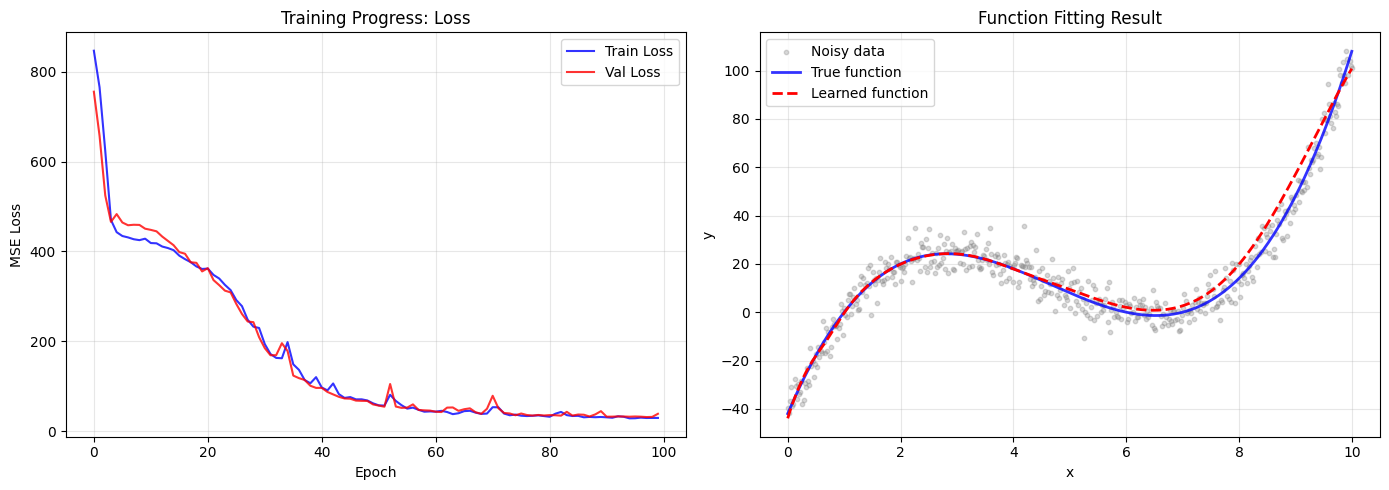

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training progress - Loss
ax1 = axes[0]
ax1.plot(train_results["train_loss"], 'b-', label="Train Loss", alpha=0.8)
ax1.plot(train_results["val_loss"], 'r-', label="Val Loss", alpha=0.8)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.set_title("Training Progress: Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Function fitting result
predictions = battery.predict(pred_full_loader)["predictions"]
y_pred = torch.cat(predictions, dim=0).cpu().numpy()
x_np = x_tensor.cpu().numpy()

ax2 = axes[1]
ax2.scatter(x_np, y_noisy, c='gray', s=10, alpha=0.3, label='Noisy data')
ax2.plot(x_np, y_clean, 'b-', linewidth=2, label='True function', alpha=0.8)
ax2.plot(x_np, y_pred, 'r--', linewidth=2, label='Learned function')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Function Fitting Result")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Summary: TensorBoard vs WandB

Both trackers received the **same metrics from the same training run**. You can now compare them:

| Feature | TensorBoard | WandB |
|---------|------------|-------|
| **Setup** | Local, no account needed | Requires account (free tier available) |
| **Storage** | Local filesystem | Cloud-based |
| **Collaboration** | Manual sharing of log files | Built-in sharing & teams |
| **Visualization** | Real-time local dashboard | Web-based dashboard |
| **Experiment Comparison** | Multiple runs in same logdir | Advanced comparison tools |
| **Best For** | Quick local experiments | Long-term tracking & collaboration |

### Key Takeaways

- **Multiple trackers**: Use `callbacks=[tb_callback, wandb_callback]` to track to multiple backends simultaneously
- **Same interface**: Both trackers use the same `Run` configuration and `ExperimentTrackingCallback`
- **Automatic logging**: Metrics are automatically logged after each epoch by the callback
- **No code changes**: Switch trackers by simply changing which callbacks you pass to `Battery`